In [1]:
# ML
import torch
import torch.nn as nn
from sklearn import datasets

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.patches import Circle, Wedge, Polygon
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv # Interactive 3D plots

# Math
import math
from math import cos, sin
import numpy as np
import random

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.style.use('seaborn')

# Set seed for reproducibility
random.seed(2019)
np.random.seed(2019)
torch.manual_seed(2019)
torch.cuda.manual_seed(12)

torch.backends.cudnn.deterministic=True

## 1 Neural Network

In [3]:
def train(x, y, model, crit, optimizer):
    idx = 0
    epochs = 1000
    print_iter = 200
    nrows = int(epochs / print_iter) + 1
    
    o = []
    
    def hook(module, input, output):
        o.append(output)
        
    model[1].register_forward_hook(hook)

    
    # Create a subplot
    fig, ax = plt.subplots(nrows=nrows, ncols=4, figsize=(14, 20))

    for epoch in range(epochs):
        y_pred = model(x)
        loss = crit(y_pred,y)
        optimizer.zero_grad()
        loss.backward()  # back pass
        optimizer.step() # update params

        if (epoch % print_iter) == 0 or (epoch == (epochs - 1)):
            """
            ax[idx][0].figure(1, figsize=(5,5))
            ax[idx][1].figure(1, figsize=(5,5))
            ax[idx][2].figure(1, figsize=(5,5))
            ax[idx][3].figure(1, figsize=(5,5))
            """
            
            plot_regions(x,y,model, ax[idx][0], "Epoch " + str(epoch))        
            # Print out model weights
            model_weights_plot(model, ax[idx][1], "Model Weights")
            # Print out the linear output values
            output_plot(model, o, ax[idx][2], "Linear Output Values")
            combined_plot(model, o, ax[idx][3], "|Ouput Value * Model Weight|")
            idx = idx + 1
        o = []

    plt.show()
    
    return loss

In [4]:
def model_weights_plot(model, s_plt, title):
    weights1 = np.array(model[0].weight.tolist())
    weights2 = np.array(model[2].weight.tolist())[0]
    s_plt.title.set_text(title)
    s_plt.bar(list(range(len(weights2))), weights2)
    s_plt.plot()
    
def output_plot(model, o, s_plt, title):
    a = np.array(o[0].tolist())
    t = np.sum(a, axis=0) / a.shape[0]
    s_plt.title.set_text(title)
    s_plt.bar(list(range(len(t))), t)
    
def combined_plot(model, o, s_plt, title):
    a = np.array(o[0].tolist())
    t = np.sum(a, axis=0) / a.shape[0]
    weights2 = np.array(model[2].weight.tolist())[0]
    c_plot = np.abs(weights2*t)
    #plt.title("|Ouput Value * Model Weight|")
    s_plt.title.set_text(title)
    s_plt.bar(list(range(len(c_plot))), c_plot)

    plt.tight_layout()
    #s_plt.plot()
    
def plot_fin_model(model, x, y):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

    
    preds, output = pred(model, x)
    output = np.array(output[0].tolist())

    x = np.array(x.tolist())
    y = np.array(y.tolist())

    # Get average output for each class
    output0 = np.array([output[i] for i, y_i in enumerate(y) if y_i == 0])
    output1 = np.array([output[i] for i, y_i in enumerate(y) if y_i == 1])
    
    # Plot final output
    plot_regions(x, y, model, ax[0][0], "Output 0")        
    # Print out model weights
    model_weights_plot(model, ax[0][1], "Model Weights")
    # Print out the linear output values
    output_plot(model, [output0], ax[0][2], "Linear Output Values")
    combined_plot(model, [output0], ax[0][3], "|Ouput Value * Model Weight|")

    # Plot final output
    plot_regions(x, y, model, ax[1][0], "Output 1")        
    # Print out model weights
    model_weights_plot(model, ax[1][1], "Model Weights")
    # Print out the linear output values
    output_plot(model, [output1], ax[1][2], "Linear Output Values")
    combined_plot(model, [output1], ax[1][3], "|Ouput Value * Model Weight|")
    
def plot_weights(model):
    layer_1_w = np.array(model[0].weight.tolist())
    layer_1_b = np.array(model[0].bias.tolist())
    layer_1_b = layer_1_b.reshape(-1, 1)
    
    weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
    fig = plt.figure(figsize = (6, 6))
    ax = Axes3D(fig, elev = -150, azim = 130)
    ax.scatter(weights[:,0], weights[:,1], weights[:,2])
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Y')
    plt.show()

In [5]:
def pred(model, x):
    o = []
        
    def hook(module, input, output):
        o.append(output)
        
    model[1].register_forward_hook(hook)
    
    #return values and outputs after first hidden layer
    return model(torch.FloatTensor(x)).tolist(), o

# MODIFIYING NUM CHANGES QUALITY & RUN-TIME DRAMATICALLY
def rand_points():
    num = 50
    x_points = np.linspace(-5.5,5.5,num)
    y_points = np.linspace(-5.5,5.5,num)
    points = [[x,y] for x in x_points for y in y_points]
    return points

def train_vals(x):
    return ([z[0] for z in x.tolist()],[z[1] for z in x.tolist()])

def plot_regions(x,y,model, s_plt, title, idx=-1):
    x_train,y_train = train_vals(x)
    points = rand_points()
    x_map = [x[0] for x in points]
    y_map = [x[1] for x in points]
    val = pred(model,points)
    preds = val[0]
    out = val[1]    
    
    
    #get colors
    c1 = ['g','b']
    c2 = ['#E2E79F','#FF90FF']
    
    #c1 = ['r', 'b']
    #c2 = ['r', 'b']
    
    train_map = [c1[int(x[0])] for x in y.tolist()]
    cmap = [c2[0] if x[0] < 0.5 else c2[1] for x in preds]
    #plot points
    #print(len(x_map))
    s_plt.title.set_text(title)
    s_plt.scatter(x_map, y_map, color=cmap, alpha=0.22,  marker='o', s=10)
    s_plt.scatter(x_train, y_train, color=train_map, alpha=0.7, marker='o', s=10)
    
    #s_plt.xlabel('X1')
    #s_plt.ylabel('X2')
    #show classification regions
    if idx == -1:
        s_plt.plot()
    else:
        plt.subplot(5,2,idx)
        
    return out

## 2 Synthetic data set generator

### 2.1 Generate circles and disks

In [6]:
def gen_circle(n, x, y, radius, disk_start=0, circ_start=0, circ_end=1, noise=False):
    """
    Generates points in within a specific disk.
    
    Args:
        - n: Number of points to generate
        - x: X-axis center of circle
        - y: Y-axis center of circle
        - radius:     Radius of circle
        - disk_start: [0, 1] where to start center of circle
        - circ_start: [0, 1] Start place of circle (Defaults 0 == 3PM).
        - circ_end:   [0, 1] End place of circle (Defaults 1 == 3PM, wraps around counter clockwise).
        - noise:      Add standard normal noise to data points
    """
    data = []
    for i in range(n):
        arc = random.uniform(circ_start, circ_end) * 2 * math.pi
        r = radius * np.sqrt(random.uniform(disk_start, 1))
        
        p_x = r * np.cos(arc) + x
        p_y = r * np.sin(arc) + y
        
        if noise:
            p_x += np.random.normal(0,1)
            p_y += np.random.normal(0,1)
            
        data.append([p_x, p_y])
    return data

### 2.2 Visualize two datasets

In [7]:
def plot(data1, data2):
    data1 = np.array(data1)
    data2 = np.array(data2)
    figure(num=None, figsize=(6, 6), dpi=120, facecolor='w', edgecolor='k')
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, aspect='equal')


    """
    axis = { 'xmin' : -10, 
             'xmax' : 10, 
             'ymin' : -10, 
             'ymax' : 10 }

    #ax2.add_artist(Circle((x, y), r, color=(1,0,0,.7)))
    plt.axis(**axis)"""
    plt.scatter(data1[:, 0], data1[:, 1])
    plt.scatter(data2[:, 0], data2[:, 1])
    plt.show()

In [8]:
def get_acc(model, x, y):
    y = np.array(y.tolist())
    predictions = np.array([1 if (p[0] >= 0.5) else 0 for p in model(torch.FloatTensor(x)).tolist()]).reshape(-1, 1)
    return np.sum(predictions == y)/len(y)

## 3 Neural net visualization

<Figure size 720x720 with 0 Axes>

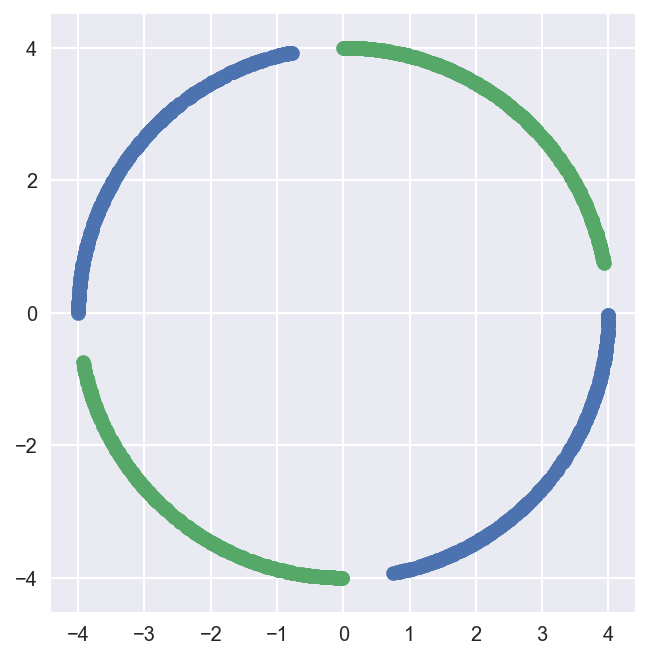

1400
1400


In [9]:
seq = np.linspace(0,1,5)
pairs = [(seq[i] + .03, seq[i+1]) for i in range(len(seq[:-1]))]

n = 250
r = 4
x = 0
y = 0

data = []
d1 = []
d2 = []
l1 = []
l2 = []

labels = []
for i, pair in enumerate(pairs):
    datum = gen_circle(350, x, y, r, disk_start = 1, circ_start = pair[0], circ_end = pair[1])
    if (i % 2):
        d1 += datum
    else:
        d2 += datum

l1 = [[1]]*len(d1)
l2 = [[0]]*len(d2)


x = torch.FloatTensor(d1 + d2)
y = l1 + l2
y = torch.FloatTensor(y)
plot(d1, d2)
print(len(x))
print(len(y))

In [10]:
def train_run_model(x, y, sgd=True, H=8):
    d = 2

    model = nn.Sequential(nn.Linear(d,H), nn.ReLU(), nn.Linear(H,1), nn.Sigmoid())
    crit = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    
    if sgd:
        optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
    
    loss = train(x,y,model,crit,optimizer)
    acc = get_acc(model, x, y)

    print("The loss is " + str(loss.tolist()))
    print("Accuracy: %.5f" % (get_acc(model, x, y)))

    return model

In [11]:
def plot_2d_weights(model):
    layer_1_w = np.array(model[0].weight.tolist())
    layer_1_b = np.array(model[0].bias.tolist())
    layer_1_b = layer_1_b.reshape(-1, 1)
    weights = layer_1_w / layer_1_b
    fig = plt.figure(figsize = (6, 6))
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')

    max_ = np.max(np.abs(weights))*1.1
    plt.xlabel("w1")
    plt.ylabel("w2")
    
    plt.xlim(-max_, max_)
    plt.ylim(-max_, max_)
    
    plt.scatter(weights[:,0], weights[:,1])
    plt.show()

## SGD Optimizer

### 3.1 SGD, ARCS = 8,  H = 8

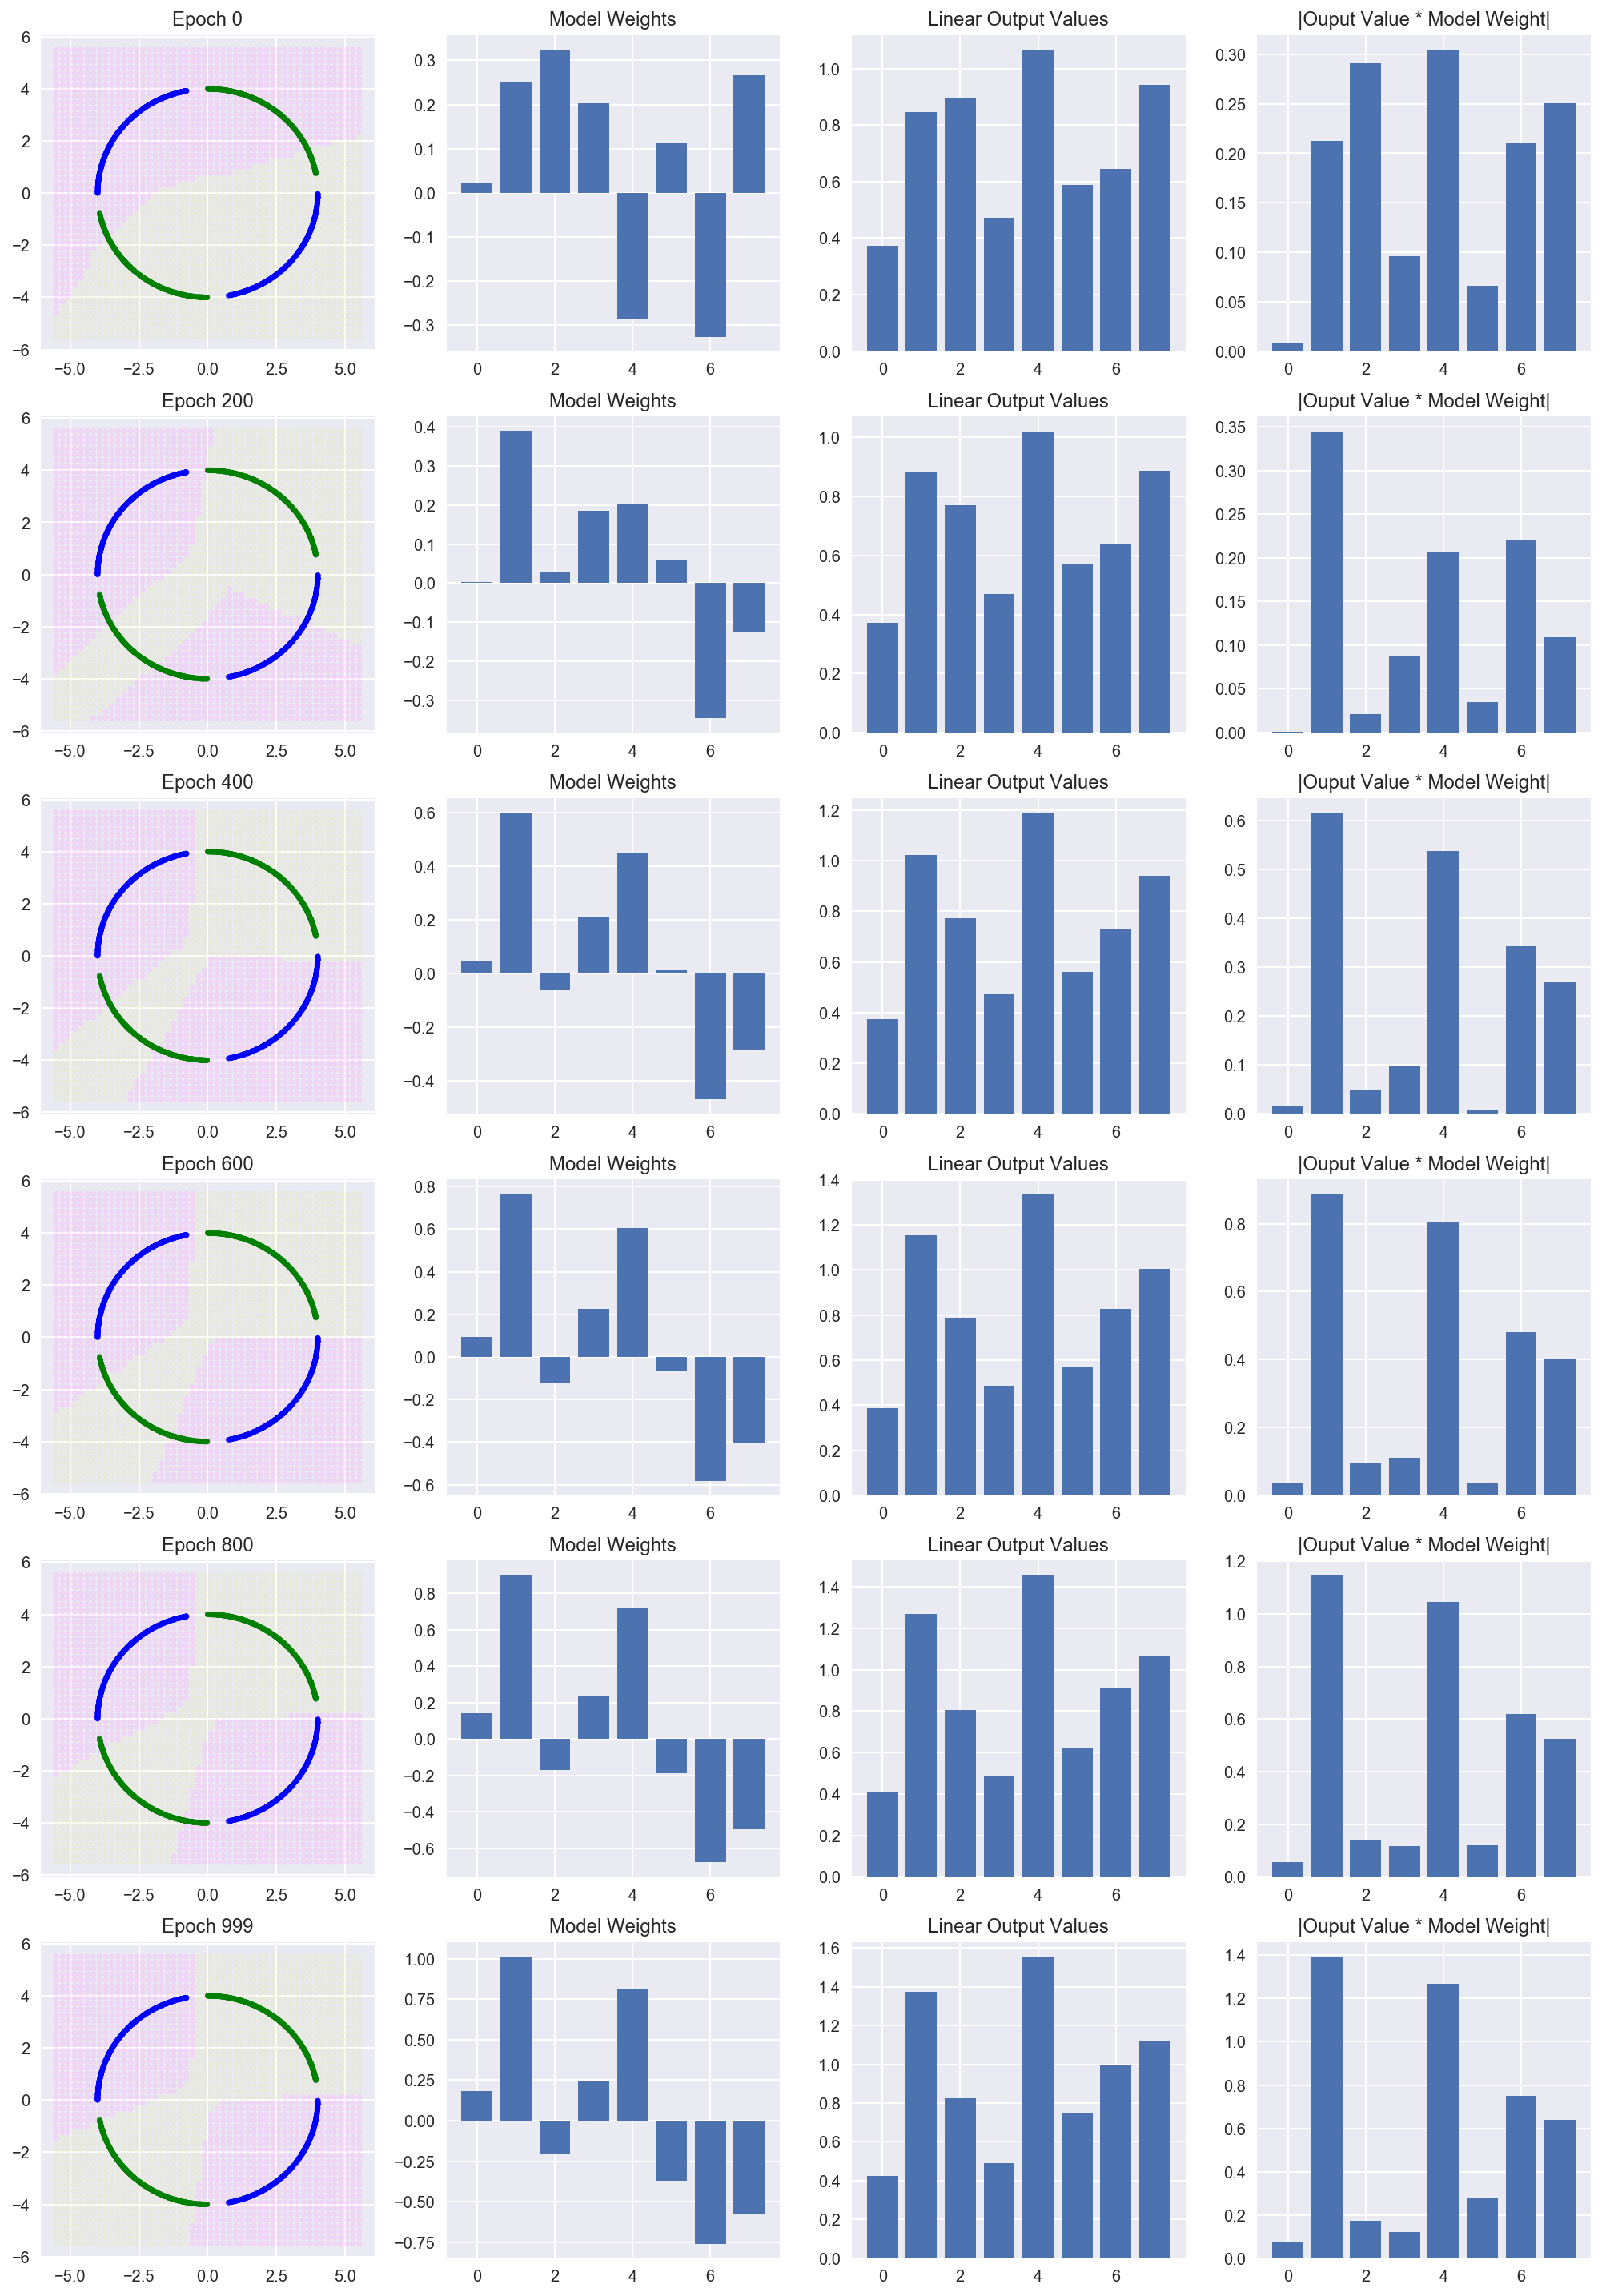

The loss is 0.19908495247364044
Accuracy: 0.97714


Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
  (3): Sigmoid()
)

In [12]:
model = train_run_model(x,y, sgd=True, H=8)
model

<IPython.core.display.Javascript object>


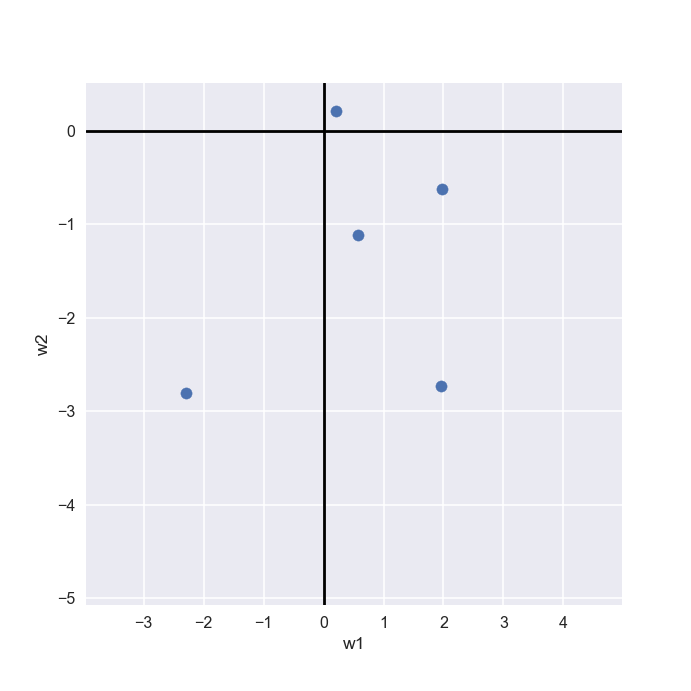

In [16]:
%matplotlib notebook
%matplotlib notebook
plot_2d_weights(model)

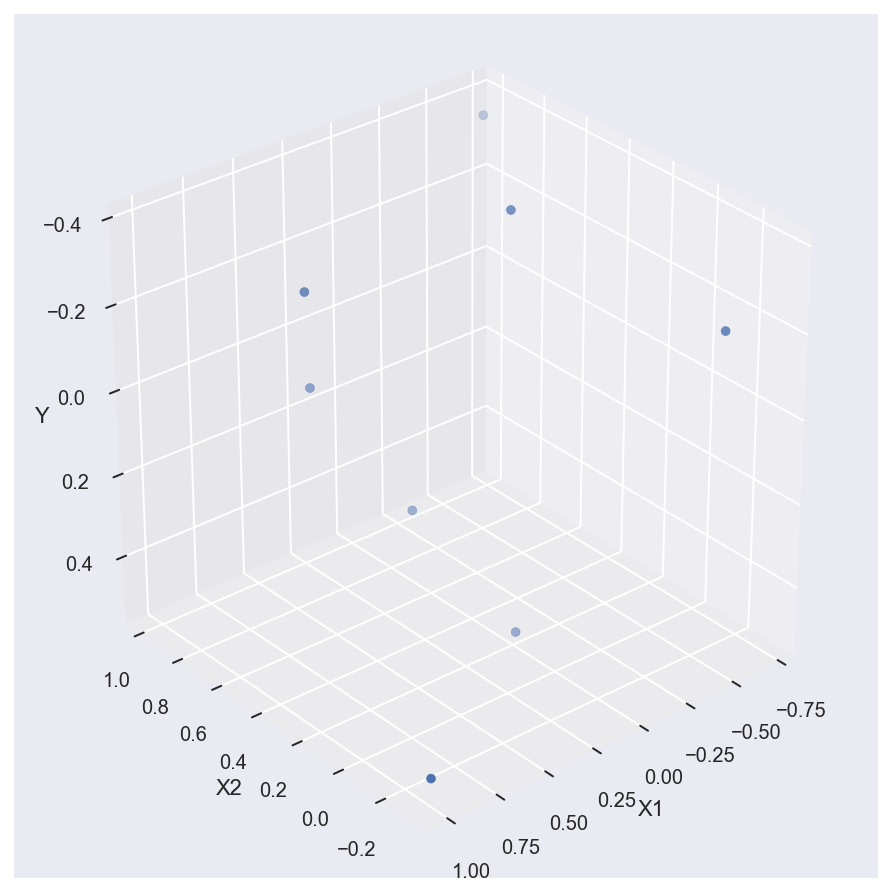

In [14]:
%matplotlib inline
plot_weights(model)

In [15]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
# ipv.pylab.xlabel('x1')
# ipv.pylab.ylabel('x1')
# ipv.pylab.zlabel('x1')

ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 3.2 SGD, ARCS = 8, H = 16

In [ ]:
model = train_run_model(x,y, sgd=True, H=16)
model

In [ ]:
%matplotlib notebook
%matplotlib notebook
plot_2d_weights(model)

In [ ]:
%matplotlib inline
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 3.3 SGD, ARCS = 8, H = 32

In [ ]:
model = train_run_model(x,y, sgd=True, H=32)
model

In [ ]:
%matplotlib notebook
%matplotlib notebook
plot_2d_weights(model)

In [ ]:
%matplotlib inline
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 3.4 SGD, ARCS = 8, H = 64

In [ ]:
model = train_run_model(x,y, sgd=True, H=64)
model

In [ ]:
%matplotlib notebook
%matplotlib notebook
plot_2d_weights(model)

In [ ]:
%matplotlib inline
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 3.5 SGD, ARCS = 8, H = 128

In [ ]:
model = train_run_model(x,y, sgd=True, H=128)
model

In [ ]:
%matplotlib notebook
%matplotlib notebook
plot_2d_weights(model)

In [ ]:
%matplotlib inline
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

## Adam Optimizer

### 4.1 Adam, ARCS = 8, H = 8

In [ ]:
model = train_run_model(x,y, sgd=False, H=8)
model

In [ ]:
%matplotlib notebook
%matplotlib notebook
plot_2d_weights(model)

In [ ]:
%matplotlib inline
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 4.2 Adam, ARCS = 8, H = 16

In [ ]:
model = train_run_model(x,y, sgd=False, H=16)
model

In [ ]:
%matplotlib notebook
%matplotlib notebook
plot_2d_weights(model)

In [ ]:
%matplotlib inline
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 4.3 Adam, ARCS = 8, H = 32

In [ ]:
model = train_run_model(x,y, sgd=False, H=32)
model

In [ ]:
%matplotlib notebook
%matplotlib notebook
plot_2d_weights(model)

In [ ]:
%matplotlib inline
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 4.4 Adam, ARCS = 8, H = 64

In [ ]:
model = train_run_model(x,y, sgd=False, H=64)
model

In [ ]:
%matplotlib notebook
%matplotlib notebook
plot_2d_weights(model)

In [ ]:
%matplotlib inline
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")

### 4.5 Adam, ARCS = 8, H = 128

In [ ]:
model = train_run_model(x,y, sgd=False, H=128)
model

In [ ]:
%matplotlib notebook
%matplotlib notebook
plot_2d_weights(model)

In [ ]:
%matplotlib inline
plot_weights(model)

In [ ]:
layer_1_w = np.array(model[0].weight.tolist())
layer_1_b = np.array(model[0].bias.tolist())
layer_1_b = layer_1_b.reshape(-1, 1)

weights = np.append(layer_1_w, layer_1_b.reshape(-1,1), axis=1)
ipv.pylab.xlabel('q')
ipv.quickscatter(weights[:,0], weights[:,1], weights[:,2], size=2, marker="sphere")